In [ ]:
run_training = False
retrain = False
find_learning_rate = False

In [ ]:
import warnings #for warning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #Seaborn is a Python data visualization library based on matplotlib
sns.set() 
from PIL import Image  #Python Imaging Library

import seaborn as sns 
import cv2              #computer vision

import os
import pathlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from os import listdir

from imageio import imread


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm



In [ ]:
#We're trying to decide whether an image contain IDC or not?
#BioSD First Week
all_images = 0
for n in range(len(document)):
    info_patient = document[n]
    for c in [0, 1]:
        patient_path = path_folder + info_patient 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        all_images += len(subfiles)
        all_images

In [ ]:
data = pd.DataFrame(index=np.arange(0, all_images), columns=["info_patient", "path", "target"])

k = 0
for n in range(len(document)):
    info_patient = document[n]
    patient_path = path_folder + info_patient 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["info_patient"] = info_patient
            k += 1  

data.head()

In [ ]:
#Data exploration analysis BioSD First Week

cancer_perc = data.groupby("info_patient").target.value_counts()/ data.groupby("info_patient").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("info_patient").size(), ax=ax[0], color="Red", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("Patches per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Blue", kde=False, bins=30) #kde kernel density estimate for smoothing

ax[1].set_title("Percentage of an image covered by IDC")
ax[1].set_ylabel("Frequency")

ax[1].set_xlabel("Percentage of the patches with IDC");
sns.countplot(data.target, palette="Set1", ax=ax[2]);

ax[2].set_xlabel("IDC Negative (0) versus IDC Positive (1)")
ax[2].set_title("How many patches contain IDC?");
data.target = data.target.astype(np.int)
#Healthy and malicious image selection
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)


In [ ]:
#IMAGE PROCESSING IMAGE SEGMENTATION
# GRAYSCALING THE CANCER IMAGES --
fig, ax = plt.subplots(3,6,figsize=(20,10))

for n in range(3):
    for m in range(6):
        idx = pos_selection[m + 6*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY),cmap='gray')
        ax[n,m].grid(False)
print('Image Matrix',len(image[1]),'pixels')
print(image[1]) #the image matrix shows the entire intensities of the parts in a  image

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.distplot(image.flatten(),kde=False) #This is to flatten the matrix and put the intensity values of all the pixels in one single row vector
plt.title('Distribution of intensity values')

#Since pixel intensity value is the primary information stored within pixels, it is a beneficial feature used for IDC Image classification

In [ ]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(image)
print('The optimal seperation value is',thresh_val)
mask=np.where(image>thresh_val,149,1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.title('Cancerous Image')

plt.subplot(1,2,2)
maskimg = mask.copy()
plt.imshow(maskimg, cmap='cividis')
plt.title('Masked Cancerous Image')

In [ ]:
from skimage import color
from skimage import io
#cv2.Sobel arguments - the image, output depth, order of derivative of x, order of derivative of y, kernel/filter matrix size
sobelx = cv2.Sobel(color.rgb2gray(image),int(cv2.CV_64F),1,0,ksize=3) #ksize=3 means we'll be using the 3x3 Sobel filter
sobely = cv2.Sobel(color.rgb2gray(image),int(cv2.CV_64F),0,1,ksize=3)

laplacian = cv2.Laplacian(color.rgb2gray(image),cv2.CV_64F)


#To plot the vertical and horizontal edge detectors side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(sobelx,cmap='gray')
plt.title('Sobel X (vertical edges)')
plt.xticks([])
plt.yticks([])

#plt.subplot(1,2,3)
#plt.imshow(sobely,cmap='gray')
#plt.xticks([])
#plt.yticks([])
#plt.title('Sobel Y (horizontal edges)')

In [ ]:
#Plotting the original image
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
#plt.imshow(color.rgb2gray(image),cmap='gray')
plt.imshow(image,cmap='gray')

plt.title('Original image')

#Now to combine the 2 sobel filters
sobel = np.sqrt(np.square(sobelx) + np.square(sobely))   #calculating the gradient of image intensity
#gradient of an image measures how it is changing
plt.subplot(1,2,2)
plt.imshow(sobel,cmap='gray')
plt.title('Sobel Filter')

# The Sobel filter performed better than Otsu/KMeans in identifying distinct cancer cells in the image

In [ ]:
#To highlight the problem areas
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(image[1:50,1:50],cmap='gray')
plt.title('Original image')
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(sobel[1:75,1:75],cmap='gray')
plt.title('Sobel Filter')
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(maskimg[1:75,1:75], cmap='gray')
plt.title('Otsu/K-Means')
plt.xticks([])
plt.yticks([])

In [ ]:
#Extracting all coordinates of image patches stored in the images. We have used coordinated for resconstructing the whole breast tissue of a patient

def coordinat_extraction(df):  #coordinat_extraction
    coordination = df.path.str.rsplit("_", n=4, expand=True)
    coordination = coordination.drop([0, 1, 4], axis=1) #coord coordination
    coordination = coordination.rename({2: "x", 3: "y"}, axis=1)
    coordination.loc[:, "x"] = coordination.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coordination.loc[:, "y"] = coordination.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coordination.x.values
    df.loc[:, "y"] = coordination.y.values
    return df

def get_cancer_dataframe(info_patient, cancer_id):
    path = path_folder + info_patient + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(info_patient):
    df_0 = get_cancer_dataframe(info_patient, "0")
    df_1 = get_cancer_dataframe(info_patient, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [ ]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))
#BINARY IMAGE FEATURE EXTRACTION FOR VISUALIZATION WITH COORDINATES

patient_ids = data.info_patient.unique()

for n in range(5):
    for m in range(3):
        info_patient = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(info_patient)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="Spectral", s=20);
        ax[n,m].set_title("Patient ID: " + info_patient)
        ax[n,m].set_xlabel("X coordination")
        ax[n,m].set_ylabel("Y coordination")

In [ ]:
#With the help of coordinations we can explore how diseased tissue looks like compared to healthy ones

def visualise_breast_tissue(info_patient, pred_df=None):
    example_df = get_patient_dataframe(info_patient) #Access parameters for a row/column pair by integer position of IDC Images.

#TAKING A PATIENT AND OBTAINING DATAFRAME WITH KORDINATS

    max_point = [example_df.y.max()-1, example_df.x.max()-1]    #Copy of the array, cast to a specified type.
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8) #Unsigned integer type
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.info_patient == info_patient].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coordination = np.int(example_df.x.values[n]) 
            y_coordination = np.int(example_df.y.values[n])
            begin_x = x_coordination - 1   
            begin_y = y_coordination - 1    
            x_end = begin_x + 50            
            y_end = begin_y + 50

#Extracting regions from images that are of completely arbitrary shape. ... Put simply; a mask allows us to focus only on the portions of the image that interests us

            grid[begin_y:y_end, begin_x:x_end] = image
            if target == 1:
                mask[begin_y:y_end, begin_x:x_end, 0] = 250
                mask[begin_y:y_end, begin_x:x_end, 1] = 0
                mask[begin_y:y_end, begin_x:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coordination) & (patient_df.y==y_coordination)].proba
                mask_proba[begin_y:y_end, begin_x:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

In [ ]:
#EXPLORATORY DATA ANALYSIS

#It is a way of visualizing, summarizing and interpreting the information that is hidden in rows and column format
example = "10264"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("x-coordination")
    ax[m].set_ylabel("y-coordination")
ax[0].set_title("Breast tissue slice of patient: " + example)
ax[1].set_title("Cancer tissue colored red \n of patient: " + example);

In [266]:
import re
from pathlib import Path
import numpy as np 
import pandas as pd
import pickle

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from skimage import io

from tqdm.notebook import tqdm
tqdm().pandas();

print('import complete')

import complete
C:\Users\mucah\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [267]:
input_path = Path.cwd()/'./input/breast-histopathology-images'
print(input_path)

c:\Users\mucah\Desktop\Biomedical Capsule\ml6\input\breast-histopathology-images


In [268]:
# Create List of Paths
path_contents = [path for path in Path.iterdir(input_path)]
# Print out the first 5 paths
path_contents[0:10]

[WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10254'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10255'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10256'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10257'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10258'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10259'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10260'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10261'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/inpu

In [269]:
def get_files_folders(path,print_summary = True):
    folders = []
    files = []
    for item in Path.iterdir(path):
        if item.is_dir():
            folders.append(item)
        else:
            files.append(item)
    if print_summary:
        print(f'There are {len(folders)} folders and {len(files)} files in folder {path.name}') 
    
    return {'folders': folders, 'files': files, 'path': path} 

In [270]:
sorted_paths = get_files_folders(input_path)

There are 281 folders and 0 files in folder breast-histopathology-images


In [271]:
patient_1 = sorted_paths['folders'][0]

for p in Path.iterdir(patient_1):
    print(p,'\n')
# In order to obtain the number of files and folders
get_files_folders(patient_1);

c:\Users\mucah\Desktop\Biomedical Capsule\ml6\input\breast-histopathology-images\10253\0 

c:\Users\mucah\Desktop\Biomedical Capsule\ml6\input\breast-histopathology-images\10253\1 

There are 2 folders and 0 files in folder 10253


In [272]:
def verify_path_contents(input_path,n_folders,n_files,print_summary = True):
    '''
    loops through all the directories in a path and checks the number of folders and files in each directory
    returns a dictionary containing a list of the matched paths and a list of the unmatched paths
    '''
    
    matched_paths = []
    unmatched_paths = []
    
    for path in Path.iterdir(input_path):
        if path.is_dir():
            folders = [sub_path for sub_path in Path.iterdir(path) if sub_path.is_dir()]
            files = [sub_path for sub_path in Path.iterdir(path) if sub_path.is_file()]

            if len(folders) != n_folders or len(files) != n_files:
                unmatched_paths.append(path)
            else:
                matched_paths.append(path)
        
    if print_summary:
        print(f'We have a total of {len(matched_paths)} matched paths, and a total of {len(unmatched_paths)} unmatched paths in {input_path.name}')
        
    return {'matched_paths':matched_paths,'unmatched_paths':unmatched_paths}

In [273]:
path_contents = verify_path_contents(input_path = input_path, n_folders = 2, n_files = 0)

We have a total of 279 matched paths, and a total of 2 unmatched paths in breast-histopathology-images


In [274]:
patient_1_paths = get_files_folders(patient_1)

There are 2 folders and 0 files in folder 10253


In [275]:
p = {}
for folder in patient_1_paths['folders']:
    p[folder.name] = get_files_folders(folder)

There are 0 folders and 479 files in folder 0
There are 0 folders and 70 files in folder 1


In [276]:

display(p['0']['files'][0:5])
display(p['1']['files'][0:5])

[WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1001_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1051_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1101_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1151_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1201_class0.png')]

[WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/1/10253_idx5_x501_y351_class1.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/1/10253_idx5_x501_y401_class1.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/1/10253_idx5_x551_y301_class1.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/1/10253_idx5_x551_y351_class1.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/1/10253_idx5_x551_y401_class1.png')]

In [277]:
def extract_all_image_paths(input_path = Path.cwd()/'./input/breast-histopathology-images'):
    image_paths = [image_path for image_path in Path.glob(input_path,pattern = '*/*/*.png')]
    return image_paths

In [278]:
image_paths = extract_all_image_paths()

In [279]:
image_paths[0:5]

[WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1001_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1051_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1101_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1151_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1201_class0.png')]

In [280]:
print(f'We have a total of {len(image_paths)} images.')

We have a total of 277524 images.


In [281]:
# let's check that we correctly extracted our paths
display(image_paths[0:3])
display(image_paths[10000:10003])

[WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1001_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1051_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1101_class0.png')]

[WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10268/0/10268_idx5_x1351_y951_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10268/0/10268_idx5_x1401_y1001_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10268/0/10268_idx5_x1401_y101_class0.png')]

In [282]:
# Extracts a dict of lists containing the informaion of each path
def extract_metadata(image_paths) -> dict:
    path_data = {'path':[],'patient_id':[],'x_coord':[] ,'y_coord':[],'target':[]}
    pattern = "\\\\(\d+)_.+_x(\d+)_y(\d+)_.+(\d)"
    for image_path in tqdm(image_paths,total = 277524):
        meta_data = re.search(pattern, str(image_path))
        
        path_data['path'].append(image_path)
        path_data['patient_id'].append(meta_data.group(1))
        path_data['x_coord'].append(meta_data.group(2))
        path_data['y_coord'].append(meta_data.group(3))
        path_data['target'].append(meta_data.group(4))
    return path_data

In [283]:
# retrieve dict of path metadata
path_data = extract_metadata(image_paths)

Let's double check that our function is extracting everything correctly

In [284]:
# extract and display the first 3 rows of each value
for value in path_data.values():
    display(value[0:3]) 

[WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1001_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1051_class0.png'),
 WindowsPath('c:/Users/mucah/Desktop/Biomedical Capsule/ml6/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1101_class0.png')]

['10253', '10253', '10253']

['1001', '1001', '1001']

['1001', '1051', '1101']

['0', '0', '0']

In [285]:
# convert dictionary to pandas dataframe --> convert path_data dict to dataframe
df = pd.DataFrame.from_dict(path_data)

In [286]:
# prints the first five rows of the dataframe
df.head()

,path,patient_id,x_coord,y_coord,target
0,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10253,1001,1001,0
1,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10253,1001,1051,0
2,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10253,1001,1101,0
3,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10253,1001,1151,0
4,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10253,1001,1201,0


In [288]:
df.iloc[:,2:5]

,x_coord,y_coord,target
0,1001,1001,0
1,1001,1051,0
2,1001,1101,0
3,1001,1151,0
4,1001,1201,0
...,...,...,...
277519,2051,901,1
277520,2051,951,1
277521,2101,1001,1
277522,2101,901,1


In [289]:
# loop through the desired columns and change the types
for col in df.iloc[:,2:5]:
    df[col] = df[col].astype('int')

In [291]:
# Function below gets the the number of patches for each patient, 
# and gets the ratio of cancerous patches to non-cancerous patches for each patient

def get_image_count_and_cancer_ratios(path_df):
    # Return the count of images per patient
    s1 = path_df.groupby('patient_id')['target'].count()
    # Return the ratio of cancerous to non-cancerous images per-patient
    s2 = path_df.groupby('patient_id')['target'].mean()

    # Merge the series into one dataframe that uses the same index
    df_summary = pd.concat([s1,s2],axis = 1)
    df_summary.columns = ['n_patches/patient','cancer_ratio']
    return df_summary

In [292]:
df_summary = get_image_count_and_cancer_ratios(path_df = df)
display(df_summary)

,n_patches/patient,cancer_ratio
patient_id,,
10253,549,0.127505
10254,848,0.089623
10255,272,0.334559
10256,468,0.250000
10257,635,0.327559
...,...,...
9346,1361,0.534166
9347,410,0.124390
9381,1326,0.096531


In [293]:
# Lets get a statistical summary of our dataframe
display (df_summary.describe())

,n_patches/patient,cancer_ratio
count,279.000000,279.000000
mean,994.709677,0.308066
std,550.603474,0.201098
min,63.000000,0.010434
25%,560.500000,0.138298
50%,967.000000,0.266602
75%,1362.000000,0.446550
max,2395.000000,0.903509


In [294]:
# set bin values for number of images
bin_values = np.linspace(0,2400,25)
# below we will group our data into bins in order to e
def get_binned_cancer_ratio_df(path_df,bin_values):
    df_summary = get_image_count_and_cancer_ratios(path_df)
    # use cut to determine which values fit into which bin
    bins = pd.cut(df_summary['n_patches/patient'], bin_values)
    # group your dataframe by the bins
    binned_df = df_summary.groupby(bins).median() 
    binned_df['non-cancer_ratio_median'] = binned_df['cancer_ratio'].apply(lambda x: 1-x)
    binned_df['n_patients_per_bin'] = df_summary['n_patches/patient'].groupby(bins).count()
    # rename cancer ratio to cancer ratio median since we are taking the median now
    binned_df.rename(columns={'cancer_ratio':'cancer_ratio_median'},inplace=True)
    return binned_df

In [295]:
binned_df = get_binned_cancer_ratio_df(df,bin_values)
binned_df # fix the average number n_imgs/patient

,n_patches/patient,cancer_ratio_median,non-cancer_ratio_median,n_patients_per_bin
n_patches/patient,,,,
"(0.0, 100.0]",78.5,0.758865,0.241135,2
"(100.0, 200.0]",158.0,0.437500,0.562500,13
"(200.0, 300.0]",236.0,0.501992,0.498008,13
"(300.0, 400.0]",352.0,0.347058,0.652942,18
"(400.0, 500.0]",452.5,0.303345,0.696655,16
"(500.0, 600.0]",557.0,0.203774,0.796226,15
"(600.0, 700.0]",635.0,0.311475,0.688525,17
"(700.0, 800.0]",749.0,0.281097,0.718903,14
"(800.0, 900.0]",839.0,0.269338,0.730662,24


In [297]:
path_df = df
#access rows and columns

In [298]:
def get_patient_df(p_id,df=df):
    return df.loc[df['patient_id']== p_id,:] 

In [299]:
from matplotlib.colors import LinearSegmentedColormap
#binary image 
def scatter_patient_xy(nrows=3,ncols=3):
    n_imgs = nrows*ncols
    # get random patient ids to plot
    p_ids = np.random.choice(df['patient_id'].unique(), size=n_imgs, replace=False)
    
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,30))
    
    colors = ['#ff70db','#9334eb']
    
    cmap = LinearSegmentedColormap.from_list(name='',colors = colors, N=2)
    
    for i,row in enumerate(axs):
        for j,ax in enumerate(row):
            p_id = p_ids[i*nrows+j]
            p_df = get_patient_df(p_id)
            
            x_coords = p_df['x_coord'].values
            y_coords = p_df['y_coord'].values
            
            min_coord = min(x_coords.max(),y_coords.max())
            s = int(4000/min_coord*15)
            
            targets = p_df['target'].values
            ax.scatter(x_coords,y_coords,c=targets,cmap=cmap,s=s,marker='s')
            ax.set_title('Patient: '+p_id)

In [300]:
def get_tissue_image_array(patient_id,pred = False):
    path_df = get_patient_df(patient_id)
    max_coord = np.max((*path_df['x_coord'],*path_df['y_coord']))
    image_dimension = max_coord + 50
    grid = 255*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    mask = 155*np.ones(shape = (image_dimension,image_dimension,3)).astype('uint8')
    for x,y,target,path in path_df[['x_coord','y_coord','target','path']].values:
        img_array = io.imread(path)
        try:
            grid[y:y+50,x:x+50] = img_array 
            # if the image is cancerous add
            if target != 0:
                mask[y:y+50,x:x+50] = [0,0,255]
        except: pass
    if pred == False:
        img = grid
    else:
        alpha = 0.8
        img  = (mask * (1.0 - alpha) + grid * alpha).astype('uint8') # converting rgb
        
    return img
            

In [301]:
def plot_tissue_images(nrows=3,ncols=3,pred = False,df=df):
    n_imgs = nrows*ncols
    p_ids = np.random.choice(df['patient_id'].unique(), size=n_imgs, replace=False)
    
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,30))
    for i,row in enumerate(axs):
        for j,ax in enumerate(row):
            p_id = p_ids[i*nrows+j]
            img = get_tissue_image_array(p_id,pred = pred)
            ax.set_title(f'Breast Tissue Slice for patient {p_id}')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img)
#plot_tissue_images(pred = True)

In [302]:
# function that accepts number of patients and returns a dataframe containing all the images for each patient. 
# prioritizes patients with higher number of patches.
def get_patients(df,n_patients=10):
    p_ids = df.groupby('patient_id')['patient_id'].count().sort_values(ascending=False).index[0:n_patients]
    df =  df.loc[df['patient_id'].isin(p_ids)].reset_index(drop=True)
    return df

In [303]:
sample_df= get_patients(df=df)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22259 entries, 0 to 22258
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        22259 non-null  object
 1   patient_id  22259 non-null  object
 2   x_coord     22259 non-null  int32 
 3   y_coord     22259 non-null  int32 
 4   target      22259 non-null  int32 
dtypes: int32(3), object(2)
memory usage: 608.8+ KB


In [304]:
sample_df.head()

,path,patient_id,x_coord,y_coord,target
0,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1001,0
1,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,101,0
2,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1051,0
3,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1101,0
4,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1151,0


In [305]:
def get_img_arrays(df,):
    # read each image array from corresponding path as grayscale and flatten the image array
    df['img_array'] = df.progress_apply(lambda x : io.imread(x['path'],as_gray=True).flatten(),axis=1) # make sure to specify axis = 1
    # get the shape of each image array and store it in the dataframe
    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape[0],axis=1) # make sure to specify axis = 1
    return df

In [306]:
sample_df = get_img_arrays(df = sample_df)

In [307]:
sample_df.head()
print(sample_df)
#pltshow(sample_df)

                                                    path patient_id  x_coord  \
0      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
1      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
2      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
3      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
4      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
...                                                  ...        ...      ...   
22254  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   
22255  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   
22256  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   
22257  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   
22258  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   

       y_coord  target                 

In [308]:
# get the count of the unique values in the column array_shape
sample_df['array_shape'].value_counts() 

2500    22155
1350       50
1950       36
2100        6
1550        4
200         3
1700        3
600         1
1600        1
Name: array_shape, dtype: int64

In [309]:
weird_imgs = sample_df[sample_df['array_shape'] != 2500] 

In [310]:
# get the shape of the dataframe before dropping the artifacts
#normalize data, variables will have the same std, thus the same weight which will help PCA to calculate relevant düzlemler
sample_df.shape 

(22259, 7)

In [311]:
# drop images using indices of the filter
sample_df.drop(weird_imgs.index,inplace=True) 

In [312]:
# get the shape of the dataframe before dropping the artifacts
sample_df.shape 

(22155, 7)

In [313]:
#PCA applying on the images extract image arrays into numpy ones
sample_df.head()

,path,patient_id,x_coord,y_coord,target,img_array,array_shape
0,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1001,0,"[0.5637870588235295, 0.5312529411764706, 0.530...",2500
1,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,101,0,"[0.4460980392156863, 0.5482250980392158, 0.377...",2500
2,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1051,0,"[0.5604686274509805, 0.5520223529411764, 0.552...",2500
3,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1101,0,"[0.5895941176470589, 0.5834780392156863, 0.605...",2500
4,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1151,0,"[0.5722560784313725, 0.4745145098039215, 0.517...",2500


#### Initialize Image Array

In [314]:
# get the number of rows in the pandas dataframe in order to determine the number of rows in our numpy array
nrows=sample_df.shape[0]
# set the number of columns to 2500, which is the length of our array
ncols=2500
# initialize the array using the information above
img_arrays= np.zeros((nrows,ncols))
print(img_arrays.shape)

(22155, 2500)


In [315]:
# add all the image arrays to the numpy array that we just initialized
for i,array in enumerate(sample_df['img_array']):
    img_arrays[i,:] = array
display(img_arrays[0:5,:])

array([[0.56378706, 0.53125294, 0.53015961, ..., 0.61252392, 0.57894902,
        0.57418627],
       [0.44609804, 0.5482251 , 0.3773498 , ..., 0.69629137, 0.62279176,
        0.62840275],
       [0.56046863, 0.55202235, 0.55264039, ..., 0.49417922, 0.54639647,
        0.49673176],
       [0.58959412, 0.58347804, 0.60557098, ..., 0.48629843, 0.49784078,
        0.52479373],
       [0.57225608, 0.47451451, 0.51727098, ..., 0.54025765, 0.46870039,
        0.60726039]])

In [316]:
from sklearn.decomposition import PCA
# n_components = 0.8, account for 80% of the variation
images_pca = PCA()
# fit the function to our image arrays
images_pca.fit(img_arrays);
print(sample_df)

                                                    path patient_id  x_coord  \
0      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
1      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
2      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
3      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
4      c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...      10268     1001   
...                                                  ...        ...      ...   
22254  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   
22255  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   
22256  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   
22257  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   
22258  c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...       9323      951   

       y_coord  target                 

In [317]:
# explained get the cumalitive sum of the explained variance ratio for each principle component
evr = np.cumsum(images_pca.explained_variance_ratio_)
# plot the explained variance ratio
fig = go.Figure(data=go.Scatter(y = evr,line=dict(color='#190b15')))
fig.update_layout(title='Variance Ratio After PCA',
                   xaxis_title='Number of Principle Components',
                   yaxis_title='Variance explained by a principal component')
fig.show()

In [318]:
# let's now apply PCA but only retrieve the first 150 components or the components that account for 80 percent of the variance
images_pca = PCA(0.8) 
# OR
images_pca = PCA(150)
images_pca.fit(img_arrays);

In [319]:
sample_df['img_array'][0].shape

(2500,)

In [320]:

sample_df['pca_array'] = sample_df['img_array'].progress_apply(lambda x: images_pca.transform([x]).flatten()) 

In [321]:
sample_df['pca_array'][0].shape

(150,)

In [322]:
sample_df.head()

,path,patient_id,x_coord,y_coord,target,img_array,array_shape,pca_array
0,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1001,0,"[0.5637870588235295, 0.5312529411764706, 0.530...",2500,"[4.742959355820072, -9.090244054285298e-05, 0...."
1,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,101,0,"[0.4460980392156863, 0.5482250980392158, 0.377...",2500,"[4.5194747520354115, -0.7444543295582092, 0.60..."
2,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1051,0,"[0.5604686274509805, 0.5520223529411764, 0.552...",2500,"[4.349263507313291, -0.4386907085038925, -0.12..."
3,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1101,0,"[0.5895941176470589, 0.5834780392156863, 0.605...",2500,"[3.180511695251857, -0.12381231191284035, 0.06..."
4,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1001,1151,0,"[0.5722560784313725, 0.4745145098039215, 0.517...",2500,"[5.058231764481978, -0.560949949756375, 0.4042..."


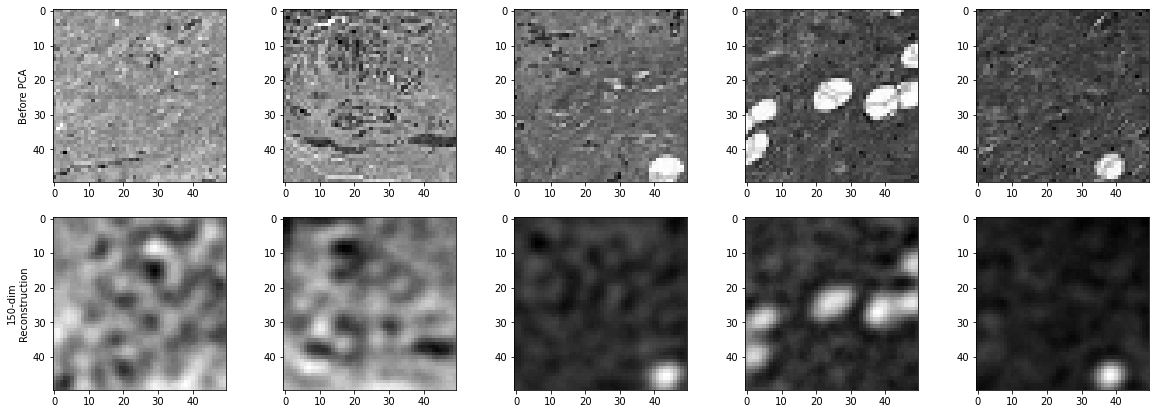

In [323]:
components = images_pca.transform(img_arrays)
projected = images_pca.inverse_transform(components)

# Plot the results
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
for i in range(5):
    ax[0, i].imshow(img_arrays[i].reshape(50, 50), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(50, 50), cmap='binary_r')
    
ax[0, 0].set_ylabel('Before PCA')
ax[1, 0].set_ylabel('150-dim\nReconstruction');

In [324]:
# get the count of each of the target values
sample_df['target'].value_counts() 

0    17949
1     4206
Name: target, dtype: int64

In [325]:
# get the dataframe containing the negative target variables
negative = sample_df[sample_df['target'] == 0]
# get the dataframe containing the positive target variables
positive = sample_df[sample_df['target'] == 1]
# get the shapes of each dataframe
display(negative.shape)
display(positive.shape)

(17949, 8)

(4206, 8)

In [326]:
from sklearn.utils import resample
# downsample the negative targets
neg_downsampled = resample(negative,n_samples=positive.shape[0], random_state=42)
# combine minority and downsampled majority
downsampled = pd.concat([positive, neg_downsampled])
# check new class counts
downsampled['target'].value_counts()

1    4206
0    4206
Name: target, dtype: int64

In [327]:
# show the first 5 values of the dataframe
downsampled.head()

,path,patient_id,x_coord,y_coord,target,img_array,array_shape,pca_array
2086,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1551,1251,1,"[0.4071949019607843, 0.40722549019607845, 0.56...",2500,"[6.490737479334456, -0.24781229433608587, 1.80..."
2087,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1551,1301,1,"[0.9172960784313726, 0.7891694117647059, 0.869...",2500,"[2.666039516871213, -0.22604141989111806, 0.34..."
2088,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1551,1351,1,"[0.5306156862745098, 0.583353725490196, 0.6286...",2500,"[3.941045831864911, 0.12971673427459415, -0.09..."
2089,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1601,1201,1,"[0.4660639215686274, 0.4910525490196078, 0.404...",2500,"[7.3446101096257905, 0.5772697703871987, -0.13..."
2090,c:\Users\mucah\Desktop\Biomedical Capsule\ml6\...,10268,1601,1251,1,"[0.5549670588235295, 0.5292203921568628, 0.521...",2500,"[7.155723519435388, 0.0037136154258522766, 0.2..."


In [328]:
# let's extract our variables of interest and store them in a new dataframe
dfd = downsampled.loc[:,['img_array','pca_array','target']]

In [329]:
dfd.head()

,img_array,pca_array,target
2086,"[0.4071949019607843, 0.40722549019607845, 0.56...","[6.490737479334456, -0.24781229433608587, 1.80...",1
2087,"[0.9172960784313726, 0.7891694117647059, 0.869...","[2.666039516871213, -0.22604141989111806, 0.34...",1
2088,"[0.5306156862745098, 0.583353725490196, 0.6286...","[3.941045831864911, 0.12971673427459415, -0.09...",1
2089,"[0.4660639215686274, 0.4910525490196078, 0.404...","[7.3446101096257905, 0.5772697703871987, -0.13...",1
2090,"[0.5549670588235295, 0.5292203921568628, 0.521...","[7.155723519435388, 0.0037136154258522766, 0.2...",1


In [330]:
# get the number of rows in the pandas dataframe in order to determine the number of rows in our numpy array
nrows=dfd.shape[0]
# set the number of columns to 150, which is the length of our array
ncols=150
# initialize the array using the information above
pca_arrays= np.zeros((nrows,ncols))
print(pca_arrays.shape)

(8412, 150)


In [331]:
# loop over the array and replace the data
for i,array in enumerate(dfd['pca_array']):
    pca_arrays[i,:] = array

In [332]:
from sklearn.model_selection import train_test_split
# split our data into training and testing data, and input data and target data
X_train, X_test, y_train, y_test =  train_test_split(pca_arrays, dfd['target'], train_size=0.7, shuffle = True)

In [333]:
# compare the shape of the train and test inputs
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (5888, 150)
X_test Shape: (2524, 150)
y_train Shape: (5888,)
y_test Shape: (2524,)


[0.66300079 0.8481215 ]
Accuracy:  75.47543581616482 %


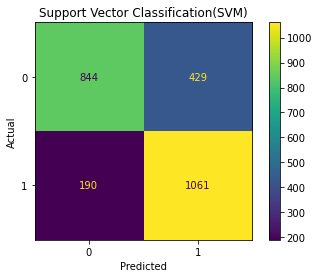

In [334]:
#A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class

from sklearn.svm import SVC #support vector classification
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn import metrics

svc_rbf = SVC(kernel = 'rbf',gamma = 'auto' )
svc_linear = SVC(kernel='linear',gamma = 'auto')
clf=SVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(clf,X_test,y_test)
matrix = confusion_matrix(y_test,y_pred)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Support Vector Classification(SVM)")

print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

### Fitting the model 

In [335]:
# fitting our models
svc_rbf.fit(X = X_train,y = y_train);
svc_linear.fit(X = X_train,y = y_train);

### Model Evaluation

In [336]:
print(svc_linear.score(X_train,y_train))
print(svc_rbf.score(X_train,y_train))

0.7105978260869565
0.7493206521739131


In [337]:
print(svc_linear.score(X_test,y_test))
print(svc_rbf.score(X_test,y_test))

0.679080824088748
0.7404912836767037


['IDC(-)', 'IDC(+)']
[0.68656716 0.65547562]
Accuracy:  67.11568938193344 %


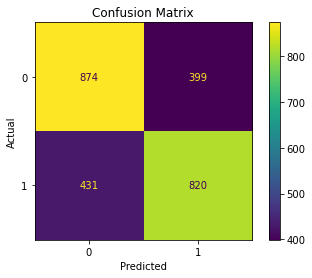

In [338]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)


plot_confusion_matrix(clf,X_test,y_test)
matrix = confusion_matrix(y_test,y_pred)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(list(map_characters.values()))    
print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

[0.73448547 0.80495604]
Accuracy:  76.94136291600634 %


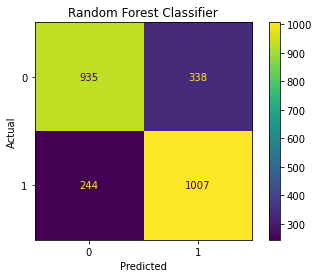

In [339]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=10)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

matrix = confusion_matrix(y_test,y_pred)

plot_confusion_matrix(clf,X_test,y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Classifier")
print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

[0.69599372 0.58593125]
Accuracy:  64.14421553090332 %


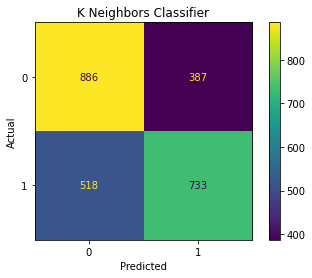

In [340]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(clf,X_test,y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("K Neighbors Classifier")
print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

[0.60879811 0.73301359]
Accuracy:  67.0364500792393 %


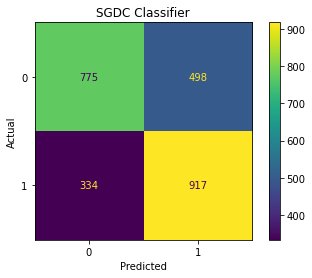

In [341]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5000)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(clf,X_test,y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SGDC Classifier")
print(matrix.diagonal()/matrix.sum(axis=1))
print("Accuracy: ", metrics.accuracy_score(y_test,y_pred)*100,"%")

In [342]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=svc_linear.predict(X_test)).ravel()

print(f'training set: true negatives: {tn}')
print(f'training set: true positives: {tp}')
print(f'training set: false negatives: {fn}')
print(f'training set: false positives: {fp}')

training set: true negatives: 828
training set: true positives: 886
training set: false negatives: 365
training set: false positives: 445


In [343]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true=y_test,y_pred=svc_rbf.predict(X_test)).ravel()

print(f'training set: true negatives: {tn}')
print(f'training set: true positives: {tp}')
print(f'training set: false negatives: {fn}')
print(f'training set: false positives: {fp}')


training set: true negatives: 791
training set: true positives: 1078
training set: false negatives: 173
training set: false positives: 482


In [344]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.svm import SVR 
from sklearn.linear_model import Ridge as RR
import seaborn as sns

In [345]:
models={'Linear Regression':LR(),'Decision Tree Regression':DTR(),'Random Forest Regression':RFR(),'Gradient Boosting Regression':GBR(),'Ada Boosting Regression':ABR(),'K-Neighbors Regression':KNR(),'Support Vector Regression':SVR(),'Ridge Regression':RR()}
pred =[]
print(models.keys())

dict_keys(['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'Gradient Boosting Regression', 'Ada Boosting Regression', 'K-Neighbors Regression', 'Support Vector Regression', 'Ridge Regression'])


In [346]:
from sklearn.metrics import r2_score
for name,algo in models.items():
    model=algo
    model.fit(X_test,y_test)
    predictions = model.predict(X_test)
    acc=r2_score(y_test, predictions)
    pred.append(acc)
    print(name,acc)

Linear Regression 0.22467189485888805
Decision Tree Regression 1.0
Random Forest Regression 0.9048281101120674
Gradient Boosting Regression 0.594978997231022
Ada Boosting Regression 0.28151616591817574
K-Neighbors Regression 0.31411587776126315
Support Vector Regression 0.5553795110269697
Ridge Regression 0.22466921435850173


In [347]:
final = DTR()
final.fit(X_train,y_train)
final_pred = final.predict(X_test)

<AxesSubplot:>

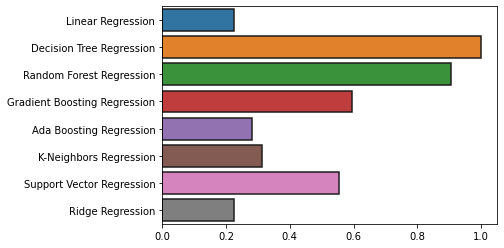

In [348]:
sns.barplot(y=list(models.keys()),x=pred,linewidth=1.5,orient ='h',edgecolor="0.1")

C:\Users\mucah\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

C:\Users\mucah\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



<AxesSubplot:xlabel='target', ylabel='Density'>

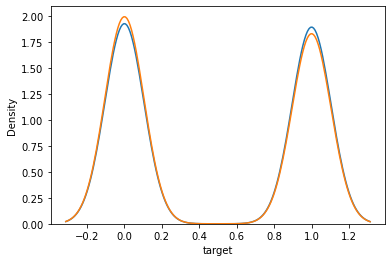

In [349]:
sns.distplot(y_test,hist = False,label ='Actual')
sns.distplot(final_pred,hist = False, label ='Predicted')

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

for n in range(3):

    idx = dev_predictions.info_patient.unique()[n*3]
    grid, mask, broken_patches, mask_proba = visualise_breast_tissue(idx, pred_df=dev_predictions)


    ax[n, 0].imshow(grid, alpha=0.9)
    ax[n, 1].imshow(mask, alpha=0.8)
    ax[n, 1].imshow(grid, alpha=0.7)
    ax[n, 2].imshow(mask_proba[:,:,0], cmap="Spectral")

    for m in range(3):
        ax[n, m].set_xlabel("y-coordination")
        ax[n, m].set_ylabel("x-coordination")
        ax[n, m].grid(False)
        
    ax[n, 0].set_title("Breast tissue slice of patient: " + info_patient)
    ax[n, 1].set_title("Masked Cancer Tissue in Red \n of patient: " + info_patient);
    ax[n, 2].set_title("Cancer Probability & Intensity");